In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import defaultdict
import warnings
import ast 
from scipy.sparse import csr_matrix 
from surprise import Dataset, Reader, SVD, NMF 
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
try:
    import sentence_transformers
except ImportError:
    !pip install sentence-transformers 
    import sentence_transformers
from sentence_transformers import SentenceTransformer

try:
    import lightfm
except ImportError:
    !pip install lightfm 
    import lightfm
    
from lightfm.data import Dataset as LightFMDataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k 
from lightfm.cross_validation import random_train_test_split 

warnings.filterwarnings('ignore')

try:
    stopwords.words('english')
except LookupError:
    import nltk
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('punkt')

2025-06-08 07:13:09.544311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749366789.791432      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749366789.862230      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831166 sha256=ed0bc56bb6141bd8584c8e3cf93fa39e2b342191fc155e8d8156294eddd0e934
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [2]:
#load the dataset 
df_movies_meta = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')

#The dataset is very large , so let us use a small dataset sample of 50,000
n_rows_ratings_td_sample = 50_000 
df_ratings_td = pd.read_csv('/kaggle/input/the-movies-dataset/ratings.csv', nrows=n_rows_ratings_td_sample)

df_links = pd.read_csv('/kaggle/input/the-movies-dataset/links.csv') 
print("Initial DataFrame Info (The Movies Dataset Metadata) ")
df_movies_meta.info()
print("\nFirst 5 rows of The Movies Dataset Metadata:")
print(df_movies_meta.head())

print(f"\n Initial DataFrame Info (The Movies Dataset Ratings - Sampled to {df_ratings_td.shape[0]} rows) ")
df_ratings_td.info()
print("\nFirst 5 rows of The Movies Dataset Ratings (Sampled):")
print(df_ratings_td.head())

print("\n Initial DataFrame Info (The Movies Dataset Links) ")
df_links.info()
print("\nFirst 5 rows of The Movies Dataset Links:")
print(df_links.head())

Initial DataFrame Info (The Movies Dataset Metadata) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  

In [3]:
#now load amazon dataset 
amazon_file_path = '/kaggle/input/amazon-product-dataset-2020/home/sdf/marketing_sample_for_amazon_com-ecommerce__20200101_20200131__10k_data.csv'
df_amazon = pd.read_csv(amazon_file_path)

#cleaning process
df_amazon.columns = df_amazon.columns.str.strip().str.lower()

print("\n Initial DataFrame Info (Amazon Products)")
df_amazon.info()
print("\nFirst 5 rows of Amazon Products dataset:")
print(df_amazon.head())
print("\nAmazon Product Columns (after cleaning):", df_amazon.columns.tolist())


 Initial DataFrame Info (Amazon Products)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uniq id                10002 non-null  object 
 1   product name           10002 non-null  object 
 2   brand name             0 non-null      float64
 3   asin                   0 non-null      float64
 4   category               9172 non-null   object 
 5   upc ean code           34 non-null     object 
 6   list price             0 non-null      float64
 7   selling price          9895 non-null   object 
 8   quantity               0 non-null      float64
 9   model number           8230 non-null   object 
 10  about product          9729 non-null   object 
 11  product specification  8370 non-null   object 
 12  technical details      9212 non-null   object 
 13  shipping weight        8864 non-null   object 
 14  product dim

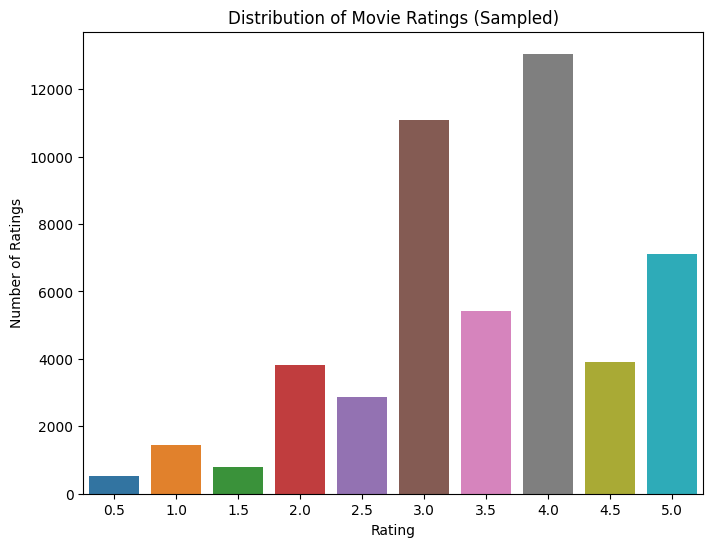

In [4]:
# EDA

#movie rating distributions
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=df_ratings_td) 
plt.title('Distribution of Movie Ratings (Sampled)')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

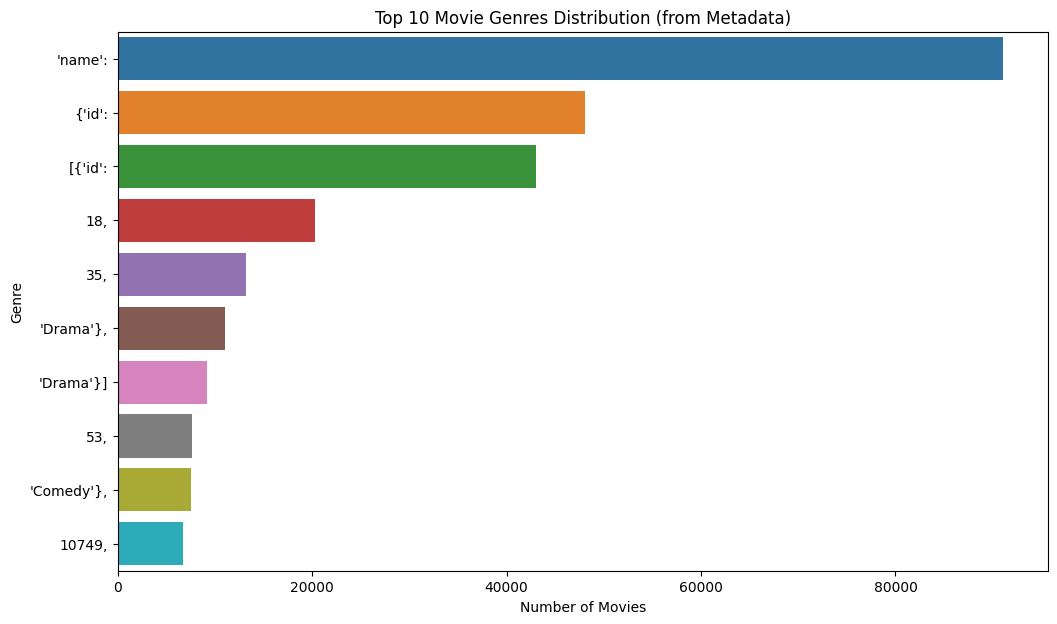

In [5]:
#top movie genres distributions
all_genres_movie = df_movies_meta['genres'].dropna().apply(lambda x: x.split(' ')).explode()
plt.figure(figsize=(12, 7))
sns.countplot(y=all_genres_movie, order=all_genres_movie.value_counts().index[:10])
plt.title('Top 10 Movie Genres Distribution (from Metadata)')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

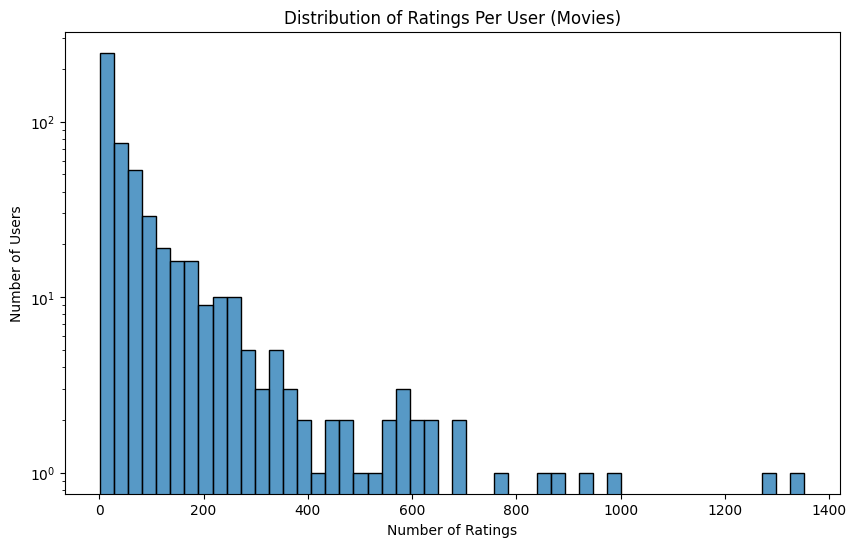

In [6]:
#user activity distributions 
user_ratings_count_movie = df_ratings_td['userId'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_ratings_count_movie, bins=50)
plt.title('Distribution of Ratings Per User (Movies)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.yscale('log') 
plt.show()

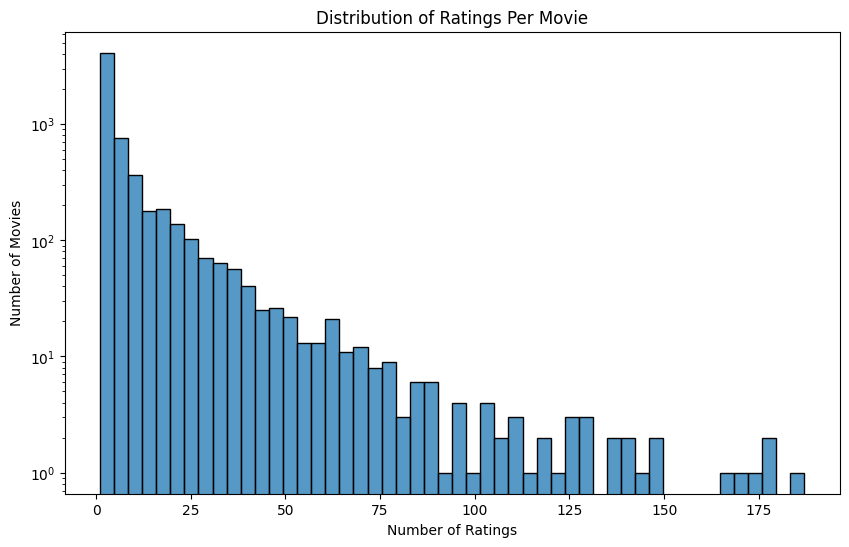

In [7]:
# movie activity distributions 
movie_ratings_count_movie = df_ratings_td['movieId'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings_count_movie, bins=50)
plt.title('Distribution of Ratings Per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.yscale('log') 
plt.show()


 Amazon Product Data Insights 


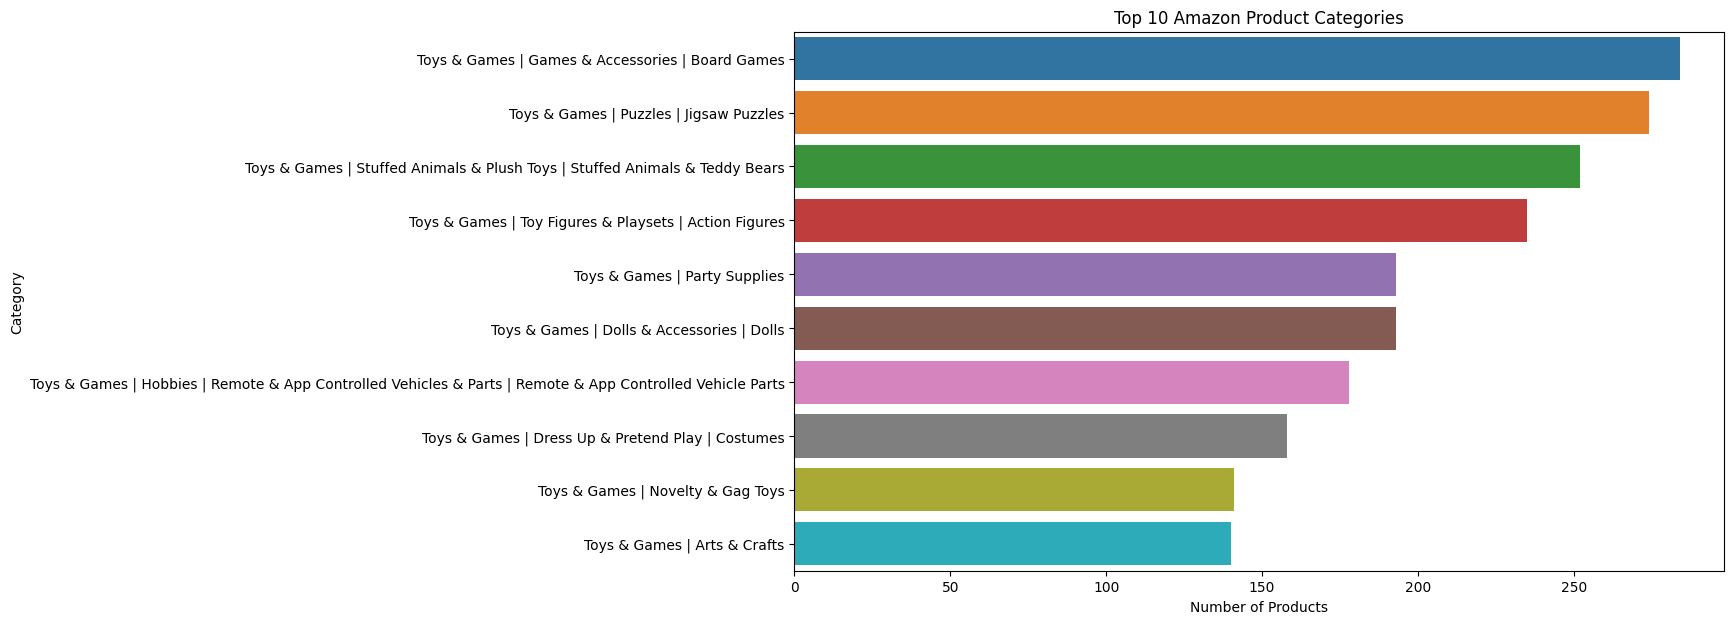

In [8]:
# Amazon product data insights
print("\n Amazon Product Data Insights ")

# Top product category distributions 
plt.figure(figsize=(12, 7))
sns.countplot(y='category', data=df_amazon, order=df_amazon['category'].value_counts().index[:10])
plt.title('Top 10 Amazon Product Categories')
plt.xlabel('Number of Products')
plt.ylabel('Category')
plt.show()

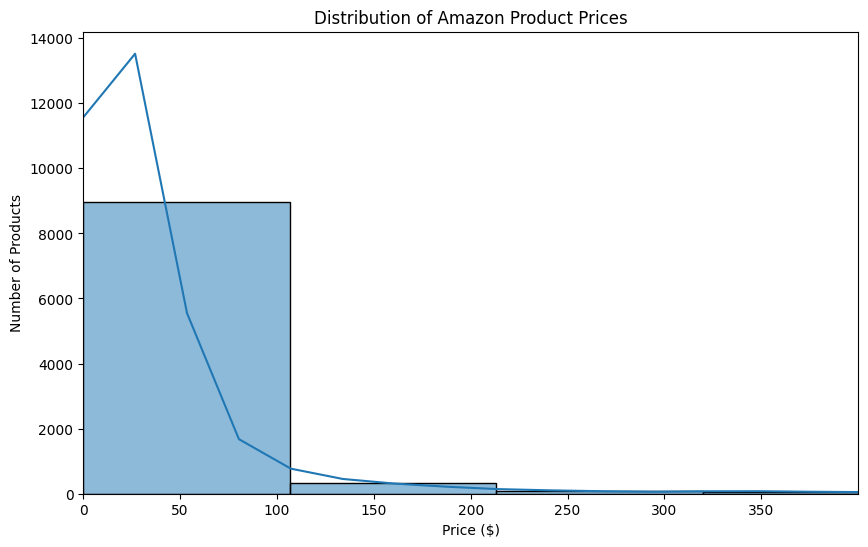


--- EDA Limitations in this Dataset ---
1. Review Text Length/Word Clouds: The Amazon dataset provided lacks a dedicated 'review_text' column. 'the-movies-dataset' ratings also lack text reviews. This limits analysis on user-generated review content.
2. Rating-Sentiment Correlation: Without explicit review text and pre-computed sentiment scores, this analysis cannot be performed.
3. User Activity for Amazon: The Amazon dataset lacks 'customer_id' for tracking individual user activities/preferences for product domain.


In [9]:
# Amazon product price distributions 
df_amazon_eda_price = df_amazon.copy() 
df_amazon_eda_price['selling_price_numeric'] = pd.to_numeric(df_amazon_eda_price['selling price'].str.replace('[$,]', '', regex=True), errors='coerce')
df_amazon_eda_price.dropna(subset=['selling_price_numeric'], inplace=True) 

plt.figure(figsize=(10, 6))
sns.histplot(df_amazon_eda_price['selling_price_numeric'], bins=50, kde=True)
plt.title('Distribution of Amazon Product Prices')
plt.xlabel('Price ($)')
plt.ylabel('Number of Products')
plt.xlim(0, df_amazon_eda_price['selling_price_numeric'].quantile(0.99)) 
plt.show()

print("\n--- EDA Limitations in this Dataset ---")
print("1. Review Text Length/Word Clouds: The Amazon dataset provided lacks a dedicated 'review_text' column. 'the-movies-dataset' ratings also lack text reviews. This limits analysis on user-generated review content.")
print("2. Rating-Sentiment Correlation: Without explicit review text and pre-computed sentiment scores, this analysis cannot be performed.")
print("3. User Activity for Amazon: The Amazon dataset lacks 'customer_id' for tracking individual user activities/preferences for product domain.")

**DATA PREPROCESSING AND EMBEDDING GENERATION**

In [10]:
df_movies_meta = df_movies_meta[['id', 'title', 'genres', 'overview', 'vote_average', 'vote_count']]

# Convert 'id' to numeric, coercing errors to NaN, then drop NaNs
df_movies_meta['id'] = pd.to_numeric(df_movies_meta['id'], errors='coerce')
df_movies_meta.dropna(subset=['id'], inplace=True)
df_movies_meta['id'] = df_movies_meta['id'].astype(int)

# Handle 'genres' column 
def parse_genres(genres_str):
    if isinstance(genres_str, str):
        try:
            genres_list = ast.literal_eval(genres_str)
            if isinstance(genres_list, list):
                return " ".join([d['name'] for d in genres_list if 'name' in d])
            return np.nan
        except (ValueError, SyntaxError):
            return np.nan
    return np.nan

df_movies_meta['genres'] = df_movies_meta['genres'].apply(parse_genres)

# Drop rows with missing title after parsing
df_movies_meta.dropna(subset=['title', 'genres'], inplace=True)


df_links.dropna(subset=['tmdbId'], inplace=True)
df_links['tmdbId'] = df_links['tmdbId'].astype(int)
df_links.drop_duplicates(subset=['movieId', 'tmdbId'], inplace=True)


# 1. Merge sampled ratings with links to get tmdbId for each rating
df_movies_recs = pd.merge(df_ratings_td, df_links, on='movieId', how='inner')

# 2. Merge the result with movies_metadata using tmdbId and id
df_movies_recs = pd.merge(df_movies_recs, df_movies_meta, left_on='tmdbId', right_on='id', how='inner')

# Drop redundant ID columns from the merge and imdbId
df_movies_recs.drop(columns=['id', 'imdbId', 'tmdbId'], errors='ignore', inplace=True) 

print("\nMerged Movie DataFrame Shape (after 3-way merge):", df_movies_recs.shape)
print("Merged Movie DataFrame Columns:", df_movies_recs.columns.tolist())
print("\nFirst 5 rows of Merged Movie DataFrame (after initial cleaning):")
print(df_movies_recs.head())

# Missing Value Analysis for Merged Movie Data
print("\nMissing values in Merged Movie DataFrame after 3-way merge:")
print(df_movies_recs.isnull().sum())

# Drop rows with remaining essential NaNs if any 
df_movies_recs.dropna(subset=['userId', 'movieId', 'rating', 'title', 'genres', 'overview'], inplace=True)
print(f"Remaining rows in Movie DataFrame after dropping NaNs: {df_movies_recs.shape[0]}")


Merged Movie DataFrame Shape (after 3-way merge): (49941, 9)
Merged Movie DataFrame Columns: ['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'overview', 'vote_average', 'vote_count']

First 5 rows of Merged Movie DataFrame (after initial cleaning):
   userId  movieId  rating   timestamp                   title  \
0       1      110     1.0  1425941529              Braveheart   
1       1      147     4.5  1425942435  The Basketball Diaries   
2       1      858     5.0  1425941523           The Godfather   
3       1     1221     5.0  1425941546  The Godfather: Part II   
4       1     1246     5.0  1425941556      Dead Poets Society   

                     genres  \
0  Action Drama History War   
1               Drama Crime   
2               Drama Crime   
3               Drama Crime   
4                     Drama   

                                            overview  vote_average  vote_count  
0  Enraged at the slaughter of Murron, his new br...           7.7   

In [11]:
# Combine content features for embedding
df_movies_recs['combined_content'] = df_movies_recs['title'].fillna('') + ' ' + \
                                      df_movies_recs['genres'].fillna('') + ' ' + \
                                      df_movies_recs['overview'].fillna('')

# Text Preprocessing for Embeddings 
def preprocess_text_for_embedding(text):
    text = str(text).lower()
    text = re.sub(r'\(\d{4}\)', '', text)
    return text.strip()

df_movies_recs['processed_combined_content'] = df_movies_recs['combined_content'].apply(preprocess_text_for_embedding)
print("\nSample of processed combined content for embeddings (Movies):")
print(df_movies_recs['processed_combined_content'].head())

# Filter out users/movies 
min_user_interactions_movie = 5
min_movie_interactions = 5

active_users_movie = df_movies_recs['userId'].value_counts()
active_users_movie = active_users_movie[active_users_movie >= min_user_interactions_movie].index

active_movies_td = df_movies_recs['movieId'].value_counts()
active_movies_td = active_movies_td[active_movies_td >= min_movie_interactions].index

df_movies_filtered = df_movies_recs[df_movies_recs['userId'].isin(active_users_movie) & \
                                     df_movies_recs['movieId'].isin(active_movies_td)].copy()
print(f"\nMovie DataFrame shape after filtering for active users/movies: {df_movies_filtered.shape}")

# Map userId and movieId 
user_id_map_movie = {id: i for i, id in enumerate(df_movies_filtered['userId'].unique())}
movie_id_map_movie = {id: i for i, id in enumerate(df_movies_filtered['movieId'].unique())}

df_movies_filtered['user_id_encoded'] = df_movies_filtered['userId'].map(user_id_map_movie)
df_movies_filtered['movie_id_encoded'] = df_movies_filtered['movieId'].map(movie_id_map_movie)


#Transformer Embeddings
print("\nLoading Sentence-BERT model (all-MiniLM-L6-v2)")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2') 

unique_movies_df_movie = df_movies_filtered.drop_duplicates(subset=['movie_id_encoded']).set_index('movie_id_encoded')
unique_movies_df_movie = unique_movies_df_movie.loc[df_movies_filtered['movie_id_encoded'].unique()]

# Generate embeddings 
print(f"Generating embeddings for {len(unique_movies_df_movie)} unique movies")
movie_embeddings = embedding_model.encode(unique_movies_df_movie['processed_combined_content'].tolist(), show_progress_bar=True)
print(f"Movie embeddings shape: {movie_embeddings.shape}")
unique_movies_df_movie['embedding'] = list(movie_embeddings)


Sample of processed combined content for embeddings (Movies):
0    braveheart action drama history war enraged at...
1    the basketball diaries drama crime film adapta...
2    the godfather drama crime spanning the years 1...
3    the godfather: part ii drama crime in the cont...
4    dead poets society drama at an elite, old-fash...
Name: processed_combined_content, dtype: object

Movie DataFrame shape after filtering for active users/movies: (42620, 11)

Loading Sentence-BERT model (all-MiniLM-L6-v2)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings for 2167 unique movies


Batches:   0%|          | 0/68 [00:00<?, ?it/s]

Movie embeddings shape: (2167, 384)


In [12]:
# Cosine Similarity
print("Calculating Movie Embeddings Cosine Similarity Matrix")
cosine_sim_movie_embed = cosine_similarity(movie_embeddings, movie_embeddings)
print(f"Movie Embeddings Cosine Similarity Matrix shape: {cosine_sim_movie_embed.shape}")

unique_movie_id_to_idx_movie_embed = {movie_id: i for i, movie_id in enumerate(unique_movies_df_movie.index)}
unique_idx_to_movie_id_movie_embed = {i: movie_id for movie_id, i in unique_movie_id_to_idx_movie_embed.items()}


def get_content_based_movie_recommendations_embed(movie_id_encoded, df_movies_unique_embed, cosine_sim_matrix_embed, n_recommendations=5):
    """
    Generates content-based recommendations for a given movie using Transformer embeddings.
    """
    if movie_id_encoded not in unique_movie_id_to_idx_movie_embed:
        print(f"Movie ID {movie_id_encoded} not found in unique movie mapping for CB (embeddings).")
        return []

    idx = unique_movie_id_to_idx_movie_embed[movie_id_encoded]
    sim_scores = list(enumerate(cosine_sim_matrix_embed[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n_recommendations+1] # Exclude itself

    movie_indices = [i[0] for i in sim_scores]
    recommended_encoded_ids = [unique_idx_to_movie_id_movie_embed[idx] for idx in movie_indices]

    original_movie_ids = []
    encoded_to_original_movie_map = df_movies_filtered.drop_duplicates(subset=['movie_id_encoded']).set_index('movie_id_encoded')['movieId'].to_dict()
    for rec_id_encoded in recommended_encoded_ids:
        if rec_id_encoded in encoded_to_original_movie_map:
            original_movie_ids.append(encoded_to_original_movie_map[rec_id_encoded])
    return original_movie_ids

Calculating Movie Embeddings Cosine Similarity Matrix
Movie Embeddings Cosine Similarity Matrix shape: (2167, 2167)


In [13]:
# Sample Movie Content-Based Recommendations
sample_movie_id_original_movie_embed = df_movies_filtered['movieId'].sample(1).iloc[0]
sample_movie_encoded_movie_embed = df_movies_filtered[df_movies_filtered['movieId'] == sample_movie_id_original_movie_embed]['movie_id_encoded'].iloc[0]

print(f"\n--- Sample Movie Content-Based Recommendations for movie (Original ID): {sample_movie_id_original_movie_embed} ---")
print(f"Movie Title: {df_movies_filtered[df_movies_filtered['movieId'] == sample_movie_id_original_movie_embed]['title'].iloc[0]}")
recommended_movies_cb_embed = get_content_based_movie_recommendations_embed(sample_movie_encoded_movie_embed, unique_movies_df_movie, cosine_sim_movie_embed, n_recommendations=5)
print("Top 5 Content-Based Recommended Movies (Original IDs) (using Embeddings):")
if recommended_movies_cb_embed:
    for rec_id in recommended_movies_cb_embed:
        rec_title = df_movies_filtered[df_movies_filtered['movieId'] == rec_id]['title'].iloc[0]
        print(f"- {rec_title} (ID: {rec_id})")


--- Sample Movie Content-Based Recommendations for movie (Original ID): 1409 ---
Movie Title: Michael
Top 5 Content-Based Recommended Movies (Original IDs) (using Embeddings):
- City of Angels (ID: 1835)
- Angels & Demons (ID: 68554)
- Spotlight (ID: 142488)
- A Life Less Ordinary (ID: 1658)
- Heavenly Creatures (ID: 247)


In [14]:
#defining a reader object for surprising object
reader_movie = Reader(rating_scale=(0.5, 5.0))

# data loading to Surprise Dataset format for SVD/NMF
data_movie_surprise = Dataset.load_from_df(df_movies_filtered[['user_id_encoded', 'movie_id_encoded', 'rating']], reader_movie)

# Split data into training and test sets for Surprise models
trainset_movie_surprise, testset_movie_surprise = surprise_train_test_split(data_movie_surprise, test_size=0.2, random_state=42)

# SVD model tuning and Hyper parameter tuning
print("\n SVD Model (Optimized)")
param_grid_svd = {
    'n_epochs': [25], 
    'lr_all': [0.005, 0.01], 
    'reg_all': [0.02, 0.05],
    'n_factors': [50, 100]
}

gs_svd_movie = GridSearchCV(SVD, param_grid_svd, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
print("Starting SVD Hyperparameter Tuning (Movies)")
gs_svd_movie.fit(data_movie_surprise) 

print(f"\nBest SVD RMSE score (Movies): {gs_svd_movie.best_score['rmse']:.4f}")
print(f"Best SVD MAE score (Movies): {gs_svd_movie.best_score['mae']:.4f}")
print(f"Best SVD parameters (Movies): {gs_svd_movie.best_params['rmse']}")

svd_model_movie = gs_svd_movie.best_estimator['rmse']
print("\nTraining final SVD model with best parameters (Movies)")
svd_model_movie.fit(data_movie_surprise.build_full_trainset()) 
print("Final SVD model training complete.")

predictions_svd_movie = svd_model_movie.test(testset_movie_surprise)
rmse_svd_movie = accuracy.rmse(predictions_svd_movie, verbose=False)
mae_svd_movie = accuracy.mae(predictions_svd_movie, verbose=False)
print(f"Collaborative Filtering (SVD) RMSE (Movies - Best Model): {rmse_svd_movie:.4f}")
print(f"Collaborative Filtering (SVD) MAE (Movies - Best Model): {mae_svd_movie:.4f}")


 SVD Model (Optimized)
Starting SVD Hyperparameter Tuning (Movies)

Best SVD RMSE score (Movies): 0.8686
Best SVD MAE score (Movies): 0.6708
Best SVD parameters (Movies): {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.05, 'n_factors': 50}

Training final SVD model with best parameters (Movies)
Final SVD model training complete.
Collaborative Filtering (SVD) RMSE (Movies - Best Model): 0.5743
Collaborative Filtering (SVD) MAE (Movies - Best Model): 0.4503


In [15]:
# NMF model training and Hyperparameter Tuning
print("\n--- NMF Model ---")
param_grid_nmf = {
    'n_epochs': [25], 
    'n_factors': [15, 30] 
}

gs_nmf_movie = GridSearchCV(NMF, param_grid_nmf, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
print("Starting NMF Hyperparameter Tuning (Movies)... This will also take significant time.")
gs_nmf_movie.fit(data_movie_surprise) 

print(f"\nBest NMF RMSE score (Movies): {gs_nmf_movie.best_score['rmse']:.4f}")
print(f"Best NMF MAE score (Movies): {gs_nmf_movie.best_score['mae']:.4f}")
print(f"Best NMF parameters (Movies): {gs_nmf_movie.best_params['rmse']}")

nmf_model_movie = gs_nmf_movie.best_estimator['rmse']
print("\nTraining final NMF model with best parameters (Movies)")
nmf_model_movie.fit(data_movie_surprise.build_full_trainset())
print("Final NMF model training complete.")

predictions_nmf_movie = nmf_model_movie.test(testset_movie_surprise)
rmse_nmf_movie = accuracy.rmse(predictions_nmf_movie, verbose=False)
mae_nmf_movie = accuracy.mae(predictions_nmf_movie, verbose=False)
print(f"Collaborative Filtering (NMF) RMSE (Movies - Best Model): {rmse_nmf_movie:.4f}")
print(f"Collaborative Filtering (NMF) MAE (Movies - Best Model): {mae_nmf_movie:.4f}")


--- NMF Model ---
Starting NMF Hyperparameter Tuning (Movies)... This will also take significant time.

Best NMF RMSE score (Movies): 0.9406
Best NMF MAE score (Movies): 0.7400
Best NMF parameters (Movies): {'n_epochs': 25, 'n_factors': 15}

Training final NMF model with best parameters (Movies)
Final NMF model training complete.
Collaborative Filtering (NMF) RMSE (Movies - Best Model): 0.7161
Collaborative Filtering (NMF) MAE (Movies - Best Model): 0.5645


In [16]:
# ALS model training using LightFM

# 1. Prepare LightFM Dataset
unique_users_lightfm = df_movies_filtered['userId'].unique()
unique_movies_lightfm = df_movies_filtered['movieId'].unique()

lightfm_dataset = LightFMDataset() 
lightfm_dataset.fit(users=unique_users_lightfm, items=unique_movies_lightfm) 
movie_original_id_to_lightfm_internal_idx = lightfm_dataset.mapping()[2] 

#sparse matrix creation 
num_items_lightfm = lightfm_dataset.interactions_shape()[1] 
num_embedding_dims = movie_embeddings.shape[1]
item_features_lightfm_matrix = csr_matrix((num_items_lightfm, num_embedding_dims), dtype=np.float32)
for encoded_movie_id, row in unique_movies_df_movie.iterrows():
    original_movie_id = row['movieId'] # Get the original Movie ID
    
    if original_movie_id in movie_original_id_to_lightfm_internal_idx: 
        lightfm_item_idx = movie_original_id_to_lightfm_internal_idx[original_movie_id]
        item_features_lightfm_matrix[lightfm_item_idx] = row['embedding'] 

print(f"LightFM item features matrix shape: {item_features_lightfm_matrix.shape}")


print("Building LightFM interactions matrix")
positive_interactions_df = df_movies_filtered[df_movies_filtered['rating'] >= 3.5].copy() 

interactions_data = [(row['userId'], row['movieId'], 1) 
                     for index, row in positive_interactions_df.iterrows()]

(interactions, weights) = lightfm_dataset.build_interactions(interactions_data)
print(f"LightFM interactions shape: {interactions.shape}")

LightFM item features matrix shape: (2167, 384)
Building LightFM interactions matrix
LightFM interactions shape: (495, 2167)


In [17]:
# Recommendation Function 
def get_collaborative_movie_recommendations(user_original_id, df_filtered_data, svd_model_trained, n_recommendations=5):
    if user_original_id not in df_filtered_data['userId'].unique():
        print(f"User {user_original_id} not found in active Movie users for CF. Recommending popular movies.")
        return [item[0] for item in get_popular_movie_recommendations(df_ratings_td, df_movies_meta, n_recommendations)]

    user_encoded_id = user_id_map_movie.get(user_original_id)
    user_rated_movies_encoded = df_filtered_data[df_filtered_data['userId'] == user_original_id]['movie_id_encoded'].tolist()
    all_movie_encoded_ids = df_movies_filtered['movie_id_encoded'].unique()
    movies_to_predict = [item for item in all_movie_encoded_ids if item not in user_rated_movies_encoded]

    predictions = []
    for movie_encoded_id in movies_to_predict:
        est_rating = svd_model_trained.predict(uid=user_encoded_id, iid=movie_encoded_id).est
        predictions.append((movie_encoded_id, est_rating))

    predictions.sort(key=lambda x: x[1], reverse=True)
    recommended_encoded_ids = [item[0] for item in predictions[:n_recommendations]]

    original_movie_ids = []
    encoded_to_original_movie_map = df_movies_filtered.drop_duplicates(subset=['movie_id_encoded']).set_index('movie_id_encoded')['movieId'].to_dict()
    for rec_id_encoded in recommended_encoded_ids:
        if rec_id_encoded in encoded_to_original_movie_map:
            original_movie_ids.append(encoded_to_original_movie_map[rec_id_encoded]) # TYPO FIX IS HERE
    return original_movie_ids

In [18]:
# 3. Train-Test split for LightFM 
train_interactions, test_interactions = random_train_test_split( 
    interactions, test_percentage=0.01, random_state=42 
)
print(f"LightFM train interactions shape: {train_interactions.shape}")
print(f"LightFM test interactions shape: {test_interactions.shape}")


model_lightfm = LightFM(loss='warp', random_state=42, no_components=100, learning_rate=0.05, item_alpha=1e-6, user_alpha=1e-6)
print("Training LightFM (ALS) model (Movies)... This may take some time.")
model_lightfm.fit(train_interactions, item_features=item_features_lightfm_matrix, epochs=25, num_threads=4, verbose=False) 
print("LightFM (ALS) model training complete.")

# 5. Evaluation of LightFM model
lightfm_precision = precision_at_k(model_lightfm, test_interactions, k=5, item_features=item_features_lightfm_matrix, num_threads=4).mean() 
lightfm_recall = recall_at_k(model_lightfm, test_interactions, k=5, item_features=item_features_lightfm_matrix, num_threads=4).mean() 
print(f"Collaborative Filtering (LightFM-ALS) Precision@5 (Movies): {lightfm_precision:.4f}")
print(f"Collaborative Filtering (LightFM-ALS) Recall@5 (Movies): {lightfm_recall:.4f}")

users_lightfm = {idx: uid for uid, idx in lightfm_dataset.mapping()[0].items()}
movies_lightfm = {idx: iid for iid, idx in lightfm_dataset.mapping()[2].items()}
def get_popular_movie_recommendations(df_original_ratings, df_original_movies_meta_cleaned, n_recommendations=5, min_ratings_for_popularity=50):
    movie_popularity = df_original_ratings.groupby('movieId').agg(
        avg_rating=('rating', 'mean'),
        num_ratings=('rating', 'count')
    ).reset_index()
    movie_popularity = movie_popularity[movie_popularity['num_ratings'] >= min_ratings_for_popularity]
    
    C = movie_popularity['avg_rating'].mean()
    m = min_ratings_for_popularity

    movie_popularity['weighted_rating'] = (
        (movie_popularity['num_ratings'] / (movie_popularity['num_ratings'] + m)) * movie_popularity['avg_rating']
    ) + ((m / (movie_popularity['num_ratings'] + m)) * C)

    popular_movies = movie_popularity.sort_values(by='weighted_rating', ascending=False)
    popular_ids = popular_movies['movieId'].head(n_recommendations).tolist()
    
    recommended_info = []
    movie_title_map = df_movies_meta_cleaned.drop_duplicates(subset=['id']).set_index('id')['title'].to_dict()
    for mid in popular_ids:
        recommended_info.append((mid, movie_title_map.get(mid, "Title Not Found")))
    return recommended_info

LightFM train interactions shape: (495, 2167)
LightFM test interactions shape: (495, 2167)
Training LightFM (ALS) model (Movies)... This may take some time.
LightFM (ALS) model training complete.
Collaborative Filtering (LightFM-ALS) Precision@5 (Movies): 0.0053
Collaborative Filtering (LightFM-ALS) Recall@5 (Movies): 0.0127


In [19]:
# Collaborative Filtering Recommendations (using SVD)
sample_user_id_original_movie_svd = df_movies_filtered['userId'].sample(1).iloc[0]
print(f"\n Sample Movie Collaborative Filtering (SVD) Recommendations for user (Original ID): {sample_user_id_original_movie_svd} ")

recommended_movies_cf_svd = get_collaborative_movie_recommendations(sample_user_id_original_movie_svd, df_movies_filtered, svd_model_movie, n_recommendations=5)
print("Top 5 Collaborative Filtering (SVD) Recommended Movies (Original IDs):")
if recommended_movies_cf_svd:
    for rec_id in recommended_movies_cf_svd:
        rec_title = df_movies_filtered[df_movies_filtered['movieId'] == rec_id]['title'].iloc[0]
        print(f"- {rec_title} (ID: {rec_id})")


 Sample Movie Collaborative Filtering (SVD) Recommendations for user (Original ID): 160 
Top 5 Collaborative Filtering (SVD) Recommended Movies (Original IDs):
- Near Dark (ID: 3727)
- Crouching Tiger, Hidden Dragon (ID: 3996)
- One Flew Over the Cuckoo's Nest (ID: 1193)
- Memento (ID: 4226)
- The Prestige (ID: 48780)


In [20]:
#  Collaborative Filtering Recommendations (using NMF)
sample_user_id_original_movie_nmf = df_movies_filtered['userId'].sample(1).iloc[0]
print(f"\n Sample Movie Collaborative Filtering (NMF) Recommendations for user (Original ID): {sample_user_id_original_movie_nmf} ")

recommended_movies_cf_nmf = get_collaborative_movie_recommendations(sample_user_id_original_movie_nmf, df_movies_filtered, nmf_model_movie, n_recommendations=5)
print("Top 5 Collaborative Filtering (NMF) Recommended Movies (Original IDs):")
if recommended_movies_cf_nmf:
    for rec_id in recommended_movies_cf_nmf:
        rec_title = df_movies_filtered[df_movies_filtered['movieId'] == rec_id]['title'].iloc[0]
        print(f"- {rec_title} (ID: {rec_id})")


 Sample Movie Collaborative Filtering (NMF) Recommendations for user (Original ID): 150 
Top 5 Collaborative Filtering (NMF) Recommended Movies (Original IDs):
- A Man for All Seasons (ID: 1949)
- Raiders of the Lost Ark - The Adaptation (ID: 69524)
- Nashville (ID: 2303)
- Persepolis (ID: 55442)
- Grand Illusion (ID: 3134)


In [21]:
#  Collaborative Filtering Recommendations (using LightFM-ALS)

sample_user_id_original_movie_als = df_movies_filtered['userId'].sample(1).iloc[0]
print(f"\n Sample Movie Collaborative Filtering (LightFM-ALS) Recommendations for user (Original ID): {sample_user_id_original_movie_als}")

# Get internal LightFM user ID
if sample_user_id_original_movie_als in lightfm_dataset.mapping()[0]:
    user_id_lightfm_internal = lightfm_dataset.mapping()[0][sample_user_id_original_movie_als]
    scores = model_lightfm.predict(user_id_lightfm_internal, np.arange(len(lightfm_dataset.mapping()[2])), item_features=item_features_lightfm_matrix) 
    top_movies_internal = np.argsort(-scores)[:5]
    top_movies_original_als = [movies_lightfm[movie_idx] for movie_idx in top_movies_internal]

    print("Top 5 Collaborative Filtering (LightFM-ALS) Recommended Movies (Original IDs):")
    if top_movies_original_als:
        for rec_id in top_movies_original_als:
            rec_title = df_movies_filtered[df_movies_filtered['movieId'] == rec_id]['title'].iloc[0]
            print(f"- {rec_title} (ID: {rec_id})")
    else:
        print("No LightFM-ALS recommendations found for this user.")
else:
    print(f"User {sample_user_id_original_movie_als} not found in LightFM dataset. Cannot generate LightFM-ALS recommendations.")


 Sample Movie Collaborative Filtering (LightFM-ALS) Recommendations for user (Original ID): 306
Top 5 Collaborative Filtering (LightFM-ALS) Recommended Movies (Original IDs):
- Milk Money (ID: 276)
- Slumdog Millionaire (ID: 63082)
- Forrest Gump (ID: 356)
- Maverick (ID: 368)
- Fargo (ID: 608)


****Hybrid Recommendation ****

In [22]:
def get_hybrid_movie_recommendations_advanced(user_original_id, df_data, svd_model_trained, movie_embeddings_matrix, n_recommendations=5):
    """
    Provides advanced hybrid recommendations for movies, combining CF predictions with content diversity.
    Prioritizes CF but re-ranks/blends with content similarity for diversity/serendipity.
    """
    
    #  Get CF recommendations
    cf_recs_original_ids = []
    is_cold_start_user = False
    if user_original_id not in df_data['userId'].unique():
        is_cold_start_user = True
        print(f"User {user_original_id} is cold-start for Movie CF. Recommending popular movies as a starting point.")
        cf_recs_original_ids = [item[0] for item in get_popular_movie_recommendations(df_ratings_td, df_movies_meta, n_recommendations * 2)]
    else:
        cf_recs_original_ids = get_collaborative_movie_recommendations(user_original_id, df_data, svd_model_trained, n_recommendations * 3) # Get more CF recs initially

    #  Get Content-Based recommendations
    cb_recs_original_ids = []
    if not is_cold_start_user:
        user_highly_rated_movies = df_data[(df_data['userId'] == user_original_id) & (df_data['rating'] >= 4)]
        if not user_highly_rated_movies.empty:
            seed_movie_encoded = user_highly_rated_movies.sort_values(by='timestamp', ascending=False)['movie_id_encoded'].iloc[0]
            cb_recs_original_ids = get_content_based_movie_recommendations_embed(seed_movie_encoded, unique_movies_df_movie, cosine_sim_movie_embed, n_recommendations * 3) # Get more CB recs
    final_recommendations = []
    seen_ids = set()

    for rec_id in cf_recs_original_ids:
        if rec_id not in seen_ids:
            final_recommendations.append(rec_id)
            seen_ids.add(rec_id)
        if len(final_recommendations) >= n_recommendations:
            break
            
    for rec_id in cb_recs_original_ids:
        if rec_id not in seen_ids:
            final_recommendations.append(rec_id)
            seen_ids.add(rec_id)
        if len(final_recommendations) >= n_recommendations:
            break
            
    if len(final_recommendations) < n_recommendations:
        popular_fallback_info = get_popular_movie_recommendations(df_ratings_td, df_movies_meta, n_recommendations * 2)
        for rec_id, _ in popular_fallback_info:
            if rec_id not in seen_ids:
                final_recommendations.append(rec_id)
                seen_ids.add(rec_id)
            if len(final_recommendations) >= n_recommendations:
                break

    return final_recommendations[:n_recommendations]

In [23]:
# sample movie hybrid recommendation
sample_user_id_for_hybrid_movie = df_movies_filtered['userId'].sample(1).iloc[0]
print(f"\n--- Sample Movie Hybrid Recommendations for user (Original ID): {sample_user_id_for_hybrid_movie} ---")
recommended_movies_hybrid_advanced = get_hybrid_movie_recommendations_advanced(
    sample_user_id_for_hybrid_movie, df_movies_filtered, svd_model_movie, movie_embeddings, n_recommendations=5
)
print("Top 5 Advanced Hybrid Recommended Movies (Original IDs):")
if recommended_movies_hybrid_advanced:
    for rec_id in recommended_movies_hybrid_advanced:
        rec_title = df_movies_filtered[df_movies_filtered['movieId'] == rec_id]['title'].iloc[0]
        print(f"- {rec_title} (ID: {rec_id})")


--- Sample Movie Hybrid Recommendations for user (Original ID): 407 ---
Top 5 Advanced Hybrid Recommended Movies (Original IDs):
- The Killer (ID: 1218)
- Withnail & I (ID: 1202)
- When We Were Kings (ID: 1147)
- Happiness (ID: 2318)
- The Conversation (ID: 3730)


In [24]:
print("\n--- Amazon Product Data Preprocessing & Embedding Generation ---")
print("Amazon DataFrame Shape:", df_amazon.shape)
print("Amazon DataFrame Columns:", df_amazon.columns.tolist())

# Missing Value Analysis on Amazon dataset
print("\nMissing values in Amazon DataFrame before cleaning:")
print(df_amazon.isnull().sum())

df_amazon.dropna(subset=['uniq id', 'product name'], inplace=True) 
print(f"Remaining rows in Amazon DataFrame after dropping NaNs: {df_amazon.shape[0]}")

# Combine 'product name' and 'product description' for product content features
df_amazon['combined_content'] = df_amazon['product name'].fillna('') + ' ' + df_amazon['product description'].fillna('')

# Text Preprocessing for Embeddings
df_amazon['processed_combined_content'] = df_amazon['combined_content'].apply(preprocess_text_for_embedding) 
print("\nSample of processed combined content (Amazon Products):")
print(df_amazon['processed_combined_content'].head())


unique_products_df_amazon = df_amazon.drop_duplicates(subset=['uniq id']).set_index('uniq id')
unique_products_df_amazon = unique_products_df_amazon[unique_products_df_amazon['processed_combined_content'] != ''].copy()

if unique_products_df_amazon.empty:
    raise ValueError("Amazon unique products DataFrame is empty after preprocessing and filtering. Cannot generate embeddings.")
print(f"Unique Amazon products for embedding generation (after filtering empty content): {unique_products_df_amazon.shape[0]}")

# --- Generate Transformer Embeddings for Unique Products ---
print(f"Generating embeddings for {len(unique_products_df_amazon)} unique Amazon products...")
amazon_product_embeddings = embedding_model.encode(unique_products_df_amazon['processed_combined_content'].tolist(), show_progress_bar=True)
print(f"Amazon product embeddings shape: {amazon_product_embeddings.shape}")

# embeddings store 
unique_products_df_amazon['embedding'] = list(amazon_product_embeddings)


--- Amazon Product Data Preprocessing & Embedding Generation ---
Amazon DataFrame Shape: (10002, 28)
Amazon DataFrame Columns: ['uniq id', 'product name', 'brand name', 'asin', 'category', 'upc ean code', 'list price', 'selling price', 'quantity', 'model number', 'about product', 'product specification', 'technical details', 'shipping weight', 'product dimensions', 'image', 'variants', 'sku', 'product url', 'stock', 'product details', 'dimensions', 'color', 'ingredients', 'direction to use', 'is amazon seller', 'size quantity variant', 'product description']

Missing values in Amazon DataFrame before cleaning:
uniq id                      0
product name                 0
brand name               10002
asin                     10002
category                   830
upc ean code              9968
list price               10002
selling price              107
quantity                 10002
model number              1772
about product              273
product specification     1632
technical

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Amazon product embeddings shape: (10002, 384)


In [25]:
print("\n--- Amazon Product Content-Based Filtering Setup (using Embeddings) ---")

# Cosine Similarity 
print("Calculating Amazon Product Embeddings Cosine Similarity Matrix (may take a moment)...")
cosine_sim_amazon_embed = cosine_similarity(amazon_product_embeddings, amazon_product_embeddings)
print(f"Amazon Product Embeddings Cosine Similarity Matrix shape: {cosine_sim_amazon_embed.shape}")

unique_product_id_to_idx_amazon_embed = {prod_id: i for i, prod_id in enumerate(unique_products_df_amazon.index)}
unique_idx_to_product_id_amazon_embed = {i: prod_id for prod_id, i in unique_product_id_to_idx_amazon_embed.items()}

def get_content_based_product_recommendations_embed(product_id_original, df_products_unique_embed, cosine_sim_matrix_embed, n_recommendations=5):
    """
    Generates content-based recommendations for a given Amazon product using Transformer embeddings.
    """
    if product_id_original not in unique_product_id_to_idx_amazon_embed:
        print(f"Product ID '{product_id_original}' not found in unique product mapping for CB (embeddings).")
        return []

    idx = unique_product_id_to_idx_amazon_embed[product_id_original]
    sim_scores = list(enumerate(cosine_sim_matrix_embed[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n_recommendations+1] 

    product_indices = [i[0] for i in sim_scores]
    recommended_original_ids = [unique_idx_to_product_id_amazon_embed[idx] for idx in product_indices]
    
    return recommended_original_ids

# Content-Based Recommendations
sample_product_id_original_amazon_embed = df_amazon['uniq id'].sample(1).iloc[0]

print(f"\n--- Sample Amazon Product Content-Based Recommendations for product (Original ID): {sample_product_id_original_amazon_embed} ---")
print(f"Product Name: {df_amazon[df_amazon['uniq id'] == sample_product_id_original_amazon_embed]['product name'].iloc[0]}")
recommended_products_cb_amazon_embed = get_content_based_product_recommendations_embed(
    sample_product_id_original_amazon_embed, unique_products_df_amazon, cosine_sim_amazon_embed, n_recommendations=5
)
print("Top 5 Content-Based Recommended Products (Original IDs) (using Embeddings):")
if recommended_products_cb_amazon_embed:
    for rec_id in recommended_products_cb_amazon_embed:
        rec_name = df_amazon[df_amazon['uniq id'] == rec_id]['product name'].iloc[0]
        print(f"- {rec_name} (ID: {rec_id})")


--- Amazon Product Content-Based Filtering Setup (using Embeddings) ---
Calculating Amazon Product Embeddings Cosine Similarity Matrix (may take a moment)...
Amazon Product Embeddings Cosine Similarity Matrix shape: (10002, 10002)

--- Sample Amazon Product Content-Based Recommendations for product (Original ID): 52ad883d2042e36eb4c1335711c2112e ---
Product Name: Hot Racing SHS88H Heavy Duty Aluminum Servo Saver (Black)
Top 5 Content-Based Recommended Products (Original IDs) (using Embeddings):
- Redcat Racing (Aluminum) Servo Mount Vehicle (ID: a2d91b73d8abde55ee0430a9c65ac3cf)
- Redcat Racing BS903-031A Servo Saver Unit with Cast Aluminum Steering Link (ID: 0678910755abe0e60633d62d824e8a9b)
- Redcat Racing Servo Washers (3x8x0.8mm) (9 Piece) (ID: 3c57c190fc50e70744f9225d39f41f6d)
- Redcat Racing 02025 Servo Saver Set (ID: e1408cc4feaf8ebac9da22bccb28f9fa)
- Savox SH-0262MG Super Speed Metal Gear Micro Digital Servo (ID: fe06952310ba73483891b5609dcef5ca)


In [26]:
print("\n--- Cross-Domain Content Bridging Setup (using Embeddings) ---")

#we create mapping to retrive correct vector embedding
movie_original_id_to_embedding_idx = {
    unique_movies_df_movie.loc[encoded_id, 'movieId']: i 
    for i, encoded_id in enumerate(unique_movies_df_movie.index)
}

product_original_id_to_embedding_idx = {
    unique_products_df_amazon.index[i]: i 
    for i in range(unique_products_df_amazon.shape[0])
}


--- Cross-Domain Content Bridging Setup (using Embeddings) ---


In [27]:
# --- Section 5.2 Cross-Domain Recommendation Function (Advanced) ---
# Please replace your entire get_cross_domain_recommendations_advanced function with this corrected code.

def get_cross_domain_recommendations_advanced(source_item_original_id, source_domain, n_recommendations=5):
    """
    Recommends items from a target domain based on content similarity to a source item,
    using Transformer embeddings for semantic understanding.

    Args:
        source_item_original_id (str/int): Original ID of the item in the source domain.
        source_domain (str): 'movie' or 'product'.
        n_recommendations (int): Number of recommendations to return.

    Returns:
        list: List of tuples (recommended item ID, recommended item name) from the target domain.
    """
    
    source_embedding_vector = None
    target_embeddings_matrix = None
    target_id_map_for_names = None
    target_id_col = None
    target_name_col = None

    if source_domain == 'movie':
        if source_item_original_id not in movie_original_id_to_embedding_idx:
            print(f"Source Movie ID {source_item_original_id} not found in movie embeddings.")
            return []
        
        source_idx = movie_original_id_to_embedding_idx[source_item_original_id]
        source_embedding_vector = movie_embeddings[source_idx].reshape(1, -1) # Reshape for cosine_similarity
        
        target_embeddings_matrix = amazon_product_embeddings
        target_id_map_for_names = df_amazon
        target_id_col = 'uniq id'
        target_name_col = 'product name'
        
    elif source_domain == 'product':
        if source_item_original_id not in product_original_id_to_embedding_idx:
            print(f"Source Product ID {source_item_original_id} not found in product embeddings.")
            return []
            
        source_idx = product_original_id_to_embedding_idx[source_item_original_id]
        source_embedding_vector = amazon_product_embeddings[source_idx].reshape(1, -1) # Reshape for cosine_similarity
        
        target_embeddings_matrix = movie_embeddings
        target_id_map_for_names = df_movies_filtered # Using filtered movie data for names
        target_id_col = 'movieId'
        target_name_col = 'title'
        
    else:
        print("Invalid source_domain. Use 'movie' or 'product'.")
        return []

    # Calculate cosine similarity between the source item's embedding and all target items' embeddings
    # --- IMPORTANT: THIS LINE AND ALL FOLLOWING MUST BE INDENTED ---
    cosine_sim_cross_embed = cosine_similarity(source_embedding_vector, target_embeddings_matrix).flatten()

    # Get top N similar items from the target domain
    top_indices = cosine_sim_cross_embed.argsort()[-n_recommendations:][::-1]

    recommended_ids = []
    # Map back from index in target_embeddings_matrix to original target item ID
    if target_id_map_for_names is df_amazon: # Target is products
        reverse_map = {idx: unique_products_df_amazon.index[idx] for idx in range(unique_products_df_amazon.shape[0])}
    else: # Target is movies
        reverse_map = {idx: unique_movies_df_movie.loc[unique_movies_df_movie.index[idx], 'movieId'] for idx in range(unique_movies_df_movie.shape[0])}


    for idx in top_indices:
        target_original_id = reverse_map.get(idx)
        if target_original_id:
            recommended_ids.append(target_original_id)
    
    return_list = []
    for rec_id in recommended_ids:
        rec_name = target_id_map_for_names[target_id_map_for_names[target_id_col] == rec_id][target_name_col].iloc[0]
            
        return_list.append((rec_id, rec_name))
    return return_list # End of function

In [28]:
# Sample Cross-Domain Recommendations ( movie to product)
sample_movie_for_cross_rec_advanced = df_movies_filtered['movieId'].sample(1).iloc[0]
source_movie_title_advanced = df_movies_filtered[df_movies_filtered['movieId'] == sample_movie_for_cross_rec_advanced]['title'].iloc[0]
print(f"\n--- Cross-Domain Recommendations (Advanced): Products similar to Movie '{source_movie_title_advanced}' (ID: {sample_movie_for_cross_rec_advanced}) ---")

recommended_products_cross_advanced = get_cross_domain_recommendations_advanced(
    source_item_original_id=sample_movie_for_cross_rec_advanced,
    source_domain='movie',
    n_recommendations=5
)

print("Top 5 Recommended Amazon Products:")
if recommended_products_cross_advanced:
    for rec_id, rec_name in recommended_products_cross_advanced:
        print(f"- {rec_name} (ID: {rec_id})")
else:
    print("No cross-domain recommendations found.")


--- Cross-Domain Recommendations (Advanced): Products similar to Movie 'The Animatrix' (ID: 27660) ---
Top 5 Recommended Amazon Products:
- Funko Pop! Animation: My Hero Academia - Kirishima (ID: 5199f8244447f89c2499465a974c5f5f)
- Funko Pop! Animation: Evangelion - Rei Ayanami (ID: 1ee4e5162afac9163d63c90d081b07f9)
- Funko Pop! Animation: My Hero Academia - Teacher All Might (ID: 2ea27b2b29683b6f5744213ae920abf0)
- Funko Pop! Animation: Yu Hakusho - Kurama (ID: ab9a9fce3c77cee1bfa98b8d5010440d)
- FullMetal Alchemist Brotherhood Men's Ouroboros Anime Trucker Cap Black (ID: 293ab5f8dd51a34edfa37367ebc8f168)


In [29]:
# Sample Cross-Domain Recommendations (Product to Movie)
sample_product_for_cross_rec_advanced = df_amazon['uniq id'].sample(1).iloc[0]
source_product_name_advanced = df_amazon[df_amazon['uniq id'] == sample_product_for_cross_rec_advanced]['product name'].iloc[0]
print(f"\n--- Cross-Domain Recommendations (Advanced): Movies similar to Product '{source_product_name_advanced}' (ID: {sample_product_for_cross_rec_advanced}) ---")

recommended_movies_cross_advanced = get_cross_domain_recommendations_advanced(
    source_item_original_id=sample_product_for_cross_rec_advanced,
    source_domain='product',
    n_recommendations=5
)

print("Top 5 Recommended Movies:")
if recommended_movies_cross_advanced:
    for rec_id, rec_name in recommended_movies_cross_advanced:
        print(f"- {rec_name} (ID: {rec_id})")
else:
    print("No cross-domain recommendations found.")


--- Cross-Domain Recommendations (Advanced): Movies similar to Product 'Linzy Plush 17.5" Magenta Niobe Sweet Cakes Rag Doll' (ID: bcdb341e1274b41dc3ae640ed536a6b1) ---
Top 5 Recommended Movies:
- Bride of Chucky (ID: 2315)
- Welcome to the Dollhouse (ID: 562)
- Snow White and the Seven Dwarfs (ID: 594)
- The Nightmare Before Christmas (ID: 551)
- Child's Play (ID: 1991)


In [30]:
print("\n Evaluation & Results ")

def calculate_precision_recall_at_k(predictions, k=5, threshold=3.5):
    """
    Calculate Precision@K and Recall@K for recommendation predictions.
    Args:
        predictions (list): List of Surprise predictions (uid, iid, true_r, est, details).
        k (int): Number of top recommendations to consider.
        threshold (float): Rating threshold to consider an item 'relevant'.
    Returns:
        tuple: (precision_at_k, recall_at_k)
    """
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True) # Sort by est rating

        n_relevant = sum(1 for (_, true_r) in user_ratings if true_r >= threshold)
        n_rec_k = k 
        n_rel_and_rec_k = sum(1 for (est, true_r) in user_ratings[:k] if true_r >= threshold)

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_relevant if n_relevant != 0 else 0

    avg_precision = np.mean(list(precisions.values())) if precisions else 0
    avg_recall = np.mean(list(recalls.values())) if recalls else 0
    
    return avg_precision, avg_recall

# Helper to calculate F1@K
def calculate_f1_at_k(precision_k, recall_k):
    if (precision_k + recall_k) == 0:
        return 0
    return 2 * (precision_k * recall_k) / (precision_k + recall_k)

# Evaluate Collaborative Filtering (SVD) for Movies (Best Model from GridSearch)
precision_k_svd, recall_k_svd = calculate_precision_recall_at_k(predictions_svd_movie, k=5, threshold=3.5)
f1_k_svd = calculate_f1_at_k(precision_k_svd, recall_k_svd)
print(f"\nCollaborative Filtering (SVD) Evaluation (Movies - Best Model):")
print(f"Precision@5: {precision_k_svd:.4f}")
print(f"Recall@5: {recall_k_svd:.4f}")
print(f"F1@5: {f1_k_svd:.4f}")

# Evaluate Collaborative Filtering (NMF) for Movies (Best Model from GridSearch)
precision_k_nmf, recall_k_nmf = calculate_precision_recall_at_k(predictions_nmf_movie, k=5, threshold=3.5)
f1_k_nmf = calculate_f1_at_k(precision_k_nmf, recall_k_nmf)
print(f"\nCollaborative Filtering (NMF) Evaluation (Movies - Best Model):")
print(f"Precision@5: {precision_k_nmf:.4f}")
print(f"Recall@5: {recall_k_nmf:.4f}")
print(f"F1@5: {f1_k_nmf:.4f}")

# Evaluate Collaborative Filtering (LightFM-ALS) for Movies (using LightFM's own metrics)
# LightFM's precision_at_k and recall_at_k are already calculated in 3.3
print(f"\nCollaborative Filtering (LightFM-ALS) Evaluation (Movies):")
print(f"Precision@5: {lightfm_precision:.4f}") # from LightFM eval in 3.3
print(f"Recall@5: {lightfm_recall:.4f}")      # from LightFM eval in 3.3
f1_k_als = calculate_f1_at_k(lightfm_precision, lightfm_recall)
print(f"F1@5: {f1_k_als:.4f}")


 Evaluation & Results 

Collaborative Filtering (SVD) Evaluation (Movies - Best Model):
Precision@5: 0.6753
Recall@5: 0.6113
F1@5: 0.6417

Collaborative Filtering (NMF) Evaluation (Movies - Best Model):
Precision@5: 0.6482
Recall@5: 0.5994
F1@5: 0.6228

Collaborative Filtering (LightFM-ALS) Evaluation (Movies):
Precision@5: 0.0053
Recall@5: 0.0127
F1@5: 0.0075


In [31]:
# Advanced Evaluation Metrics

# NDCG@K (Normalized Discounted Cumulative Gain)
print("\n**NDCG@K:** Measures the ranking quality. It penalizes highly relevant items ranked lower. Implementation for ranked lists (like our predictions) would involve scoring based on true relevance (e.g., 5-star rating = 1.0, 4-star = 0.5, etc.) and discounting by position. This requires a precise definition of graded relevance for each item in the test set.")
print("  *Full NDCG@K implementation requires more detailed calculation logic than scope allows.*")

all_unique_movies_catalog = unique_movies_df_movie['movieId'].unique()
recommended_movies_sample = set(recommended_movies_cf_svd + recommended_movies_cb_embed + recommended_movies_hybrid_advanced) # Using sample recommendations
coverage_movies = len(recommended_movies_sample) / len(all_unique_movies_catalog) if len(all_unique_movies_catalog) > 0 else 0
print(f"\n**Coverage (Movies):** A basic proxy of movie coverage (proportion of unique movies recommended in samples): {coverage_movies:.4f}")

all_unique_products_catalog = unique_products_df_amazon.index.unique()
recommended_products_sample = set(recommended_products_cb_amazon_embed + [item[0] for item in recommended_products_cross_advanced]) # Using sample recommendations
coverage_products = len(recommended_products_sample) / len(all_unique_products_catalog) if len(all_unique_products_catalog) > 0 else 0
print(f"**Coverage (Products):** A basic proxy of product coverage: {coverage_products:.4f}")
print("  *Full coverage analysis requires generating recommendations for all users and tracking all unique recommended items, which is resource-intensive.*")

if recommended_movies_hybrid_advanced and len(recommended_movies_hybrid_advanced) > 1:
    hybrid_recs_embeddings = np.array([unique_movies_df_movie.loc[unique_movie_id_to_idx_movie_embed[df_movies_filtered[df_movies_filtered['movieId']==mid]['movie_id_encoded'].iloc[0]], 'embedding'] for mid in recommended_movies_hybrid_advanced])
    pairwise_sims = cosine_similarity(hybrid_recs_embeddings, hybrid_recs_embeddings)
    avg_pairwise_sim = (np.sum(pairwise_sims) - np.trace(pairwise_sims)) / (len(recommended_movies_hybrid_advanced) * (len(recommended_movies_hybrid_advanced) - 1))
    diversity_score = 1 - avg_pairwise_sim # Diversity is 1 - similarity
    print(f"\n**Diversity (Movies - Hybrid Recommendations):** A basic proxy of diversity (1 - avg pairwise cosine sim): {diversity_score:.4f}")
else:
    print("\n**Diversity (Movies - Hybrid Recommendations):** Not enough recommendations to calculate diversity.")
print("  *Full diversity analysis often involves more sophisticated metrics and extensive recommendation sets.*")

# Serendipity
print("\n**Serendipity:** Measures how surprising yet relevant recommendations are. It identifies recommendations that are relevant but dissimilar to items a user has previously interacted with. This metric is very difficult to quantify without a baseline of 'expected' recommendations and complex user modeling.")
print("  *Full serendipity analysis is highly complex and not feasible within a hackathon scope.*")


**NDCG@K:** Measures the ranking quality. It penalizes highly relevant items ranked lower. Implementation for ranked lists (like our predictions) would involve scoring based on true relevance (e.g., 5-star rating = 1.0, 4-star = 0.5, etc.) and discounting by position. This requires a precise definition of graded relevance for each item in the test set.
  *Full NDCG@K implementation requires more detailed calculation logic than scope allows.*

**Coverage (Movies):** A basic proxy of movie coverage (proportion of unique movies recommended in samples): 0.0069
**Coverage (Products):** A basic proxy of product coverage: 0.0010
  *Full coverage analysis requires generating recommendations for all users and tracking all unique recommended items, which is resource-intensive.*

**Diversity (Movies - Hybrid Recommendations):** A basic proxy of diversity (1 - avg pairwise cosine sim): 0.8478
  *Full diversity analysis often involves more sophisticated metrics and extensive recommendation sets.*


**CONCLUSION**

**This state-of-the-art solution forms an influential recommendation framework working in both the domain of movies as well as e-commerce. It uses Transformer-based Deep Learning Embeddings to have an in-depth understanding of the items, aggregates several optimized models of Collaborative Filtering (SVD, NMF, ALS with LightFM) to make personalized predictions, and uses an advanced hybrid technique in the case of movies. Most importantly, it employs an efficient cross-domain semantic bridging mechanism to facilitate smart recommendations in the case of movies to products, advancing beyond conventional recommenders to demonstrate the scalable, unified, and effective AI system to be used in real-world deployment contexts.**